In [2]:
import operator
import random
import os,sys,shutil, glob, copy

import pandas as pd
import math
import matplotlib.pyplot as plt
import re

import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [5]:
# model file name & Observed well name import
model_ws = './KOSSG_0329/230522_steady'
prefix = ['BH-1','BH-2','MW-1','MW-2','MW-3','MW-4','MW-5','DJ-1','NDMW-09','NDMW-11','NDMW-12','NDMW-13']
prefix.sort()

In [6]:
# Removed previous result
command = '''#!/bin/bash
cd %s
# get prefix of model
prefix=$(cat batch.pfx)
echo $prefix

# remove output files.
rm "$prefix"o.*
rm scratch*
rm local*
rm *.dbg
rm array*
#rm parallel*
rm debug*
rm progress*
rm *.control'''%(model_ws)
os.system(command)

NG_ss


0

In [7]:
# Excute HGS program
command = 'cd %s && grok.x > nul && hgs.x > nul && hsplot.x > nul'%(model_ws)
os.system(command)

 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 @@                                                                      @@ 
 @@   GROK: Pre-processor for HydroGeoSphere                             @@
 @@                                                                      @@ 
 @@   REVISION:   2006                                                   @@
 @@   BUILD DATE: 20190329                                               @@
 @@   BUILD INFO: 64bit                                                  @@
 @@                                                                      @@ 
 @@   (c) Aquanty, Inc.                                                  @@
 @@       www.aquanty.com                                                @@ 
 @@       support@aquanty.com                                            @@
 @@                                                                      @@ 
 @@  

0

In [16]:
# Import OBS data
head_obs = pd.read_csv('./obs_data/transient_head.csv')

head_avg = pd.DataFrame({'well': head_obs['well'], 'average': head_obs['average']})
elevation = pd.DataFrame({'well': head_obs['well'], 'elevation': head_obs['elevation']})

flow_ = '/*.observation_well_flow.*'

files = glob.glob(model_ws + flow_)

result_dict = {}

# 각 파일에 대해 수행할 작업
for file in files:
    # 파일 이름에서 관측소 이름 추출
    with open(file, 'r') as f:
        lines = f.readlines()
        well_name = re.search(r'zone\s+t="(.+)"', lines[2]).group(1)
        last_line = lines[-1]
        last_values = last_line.split()
        H = float(last_values[0])
        result_dict[well_name] = H

average_dict = head_avg.set_index('well')['average'].to_dict()
z = elevation.set_index('well')['elevation'].to_dict()

# 각 dict 합치기
combined_dict = {k: {'average': average_dict[k], 'Z': z[k], 'H': result_dict[k]} for k in result_dict}

# 각각의 Z-H 값 계산하고 추가하기
for k in combined_dict:
    combined_dict[k]['DTW_S'] = combined_dict[k]['Z'] - combined_dict[k]['H']
    combined_dict[k]['DTW_O'] = combined_dict[k]['Z'] - combined_dict[k]['average']

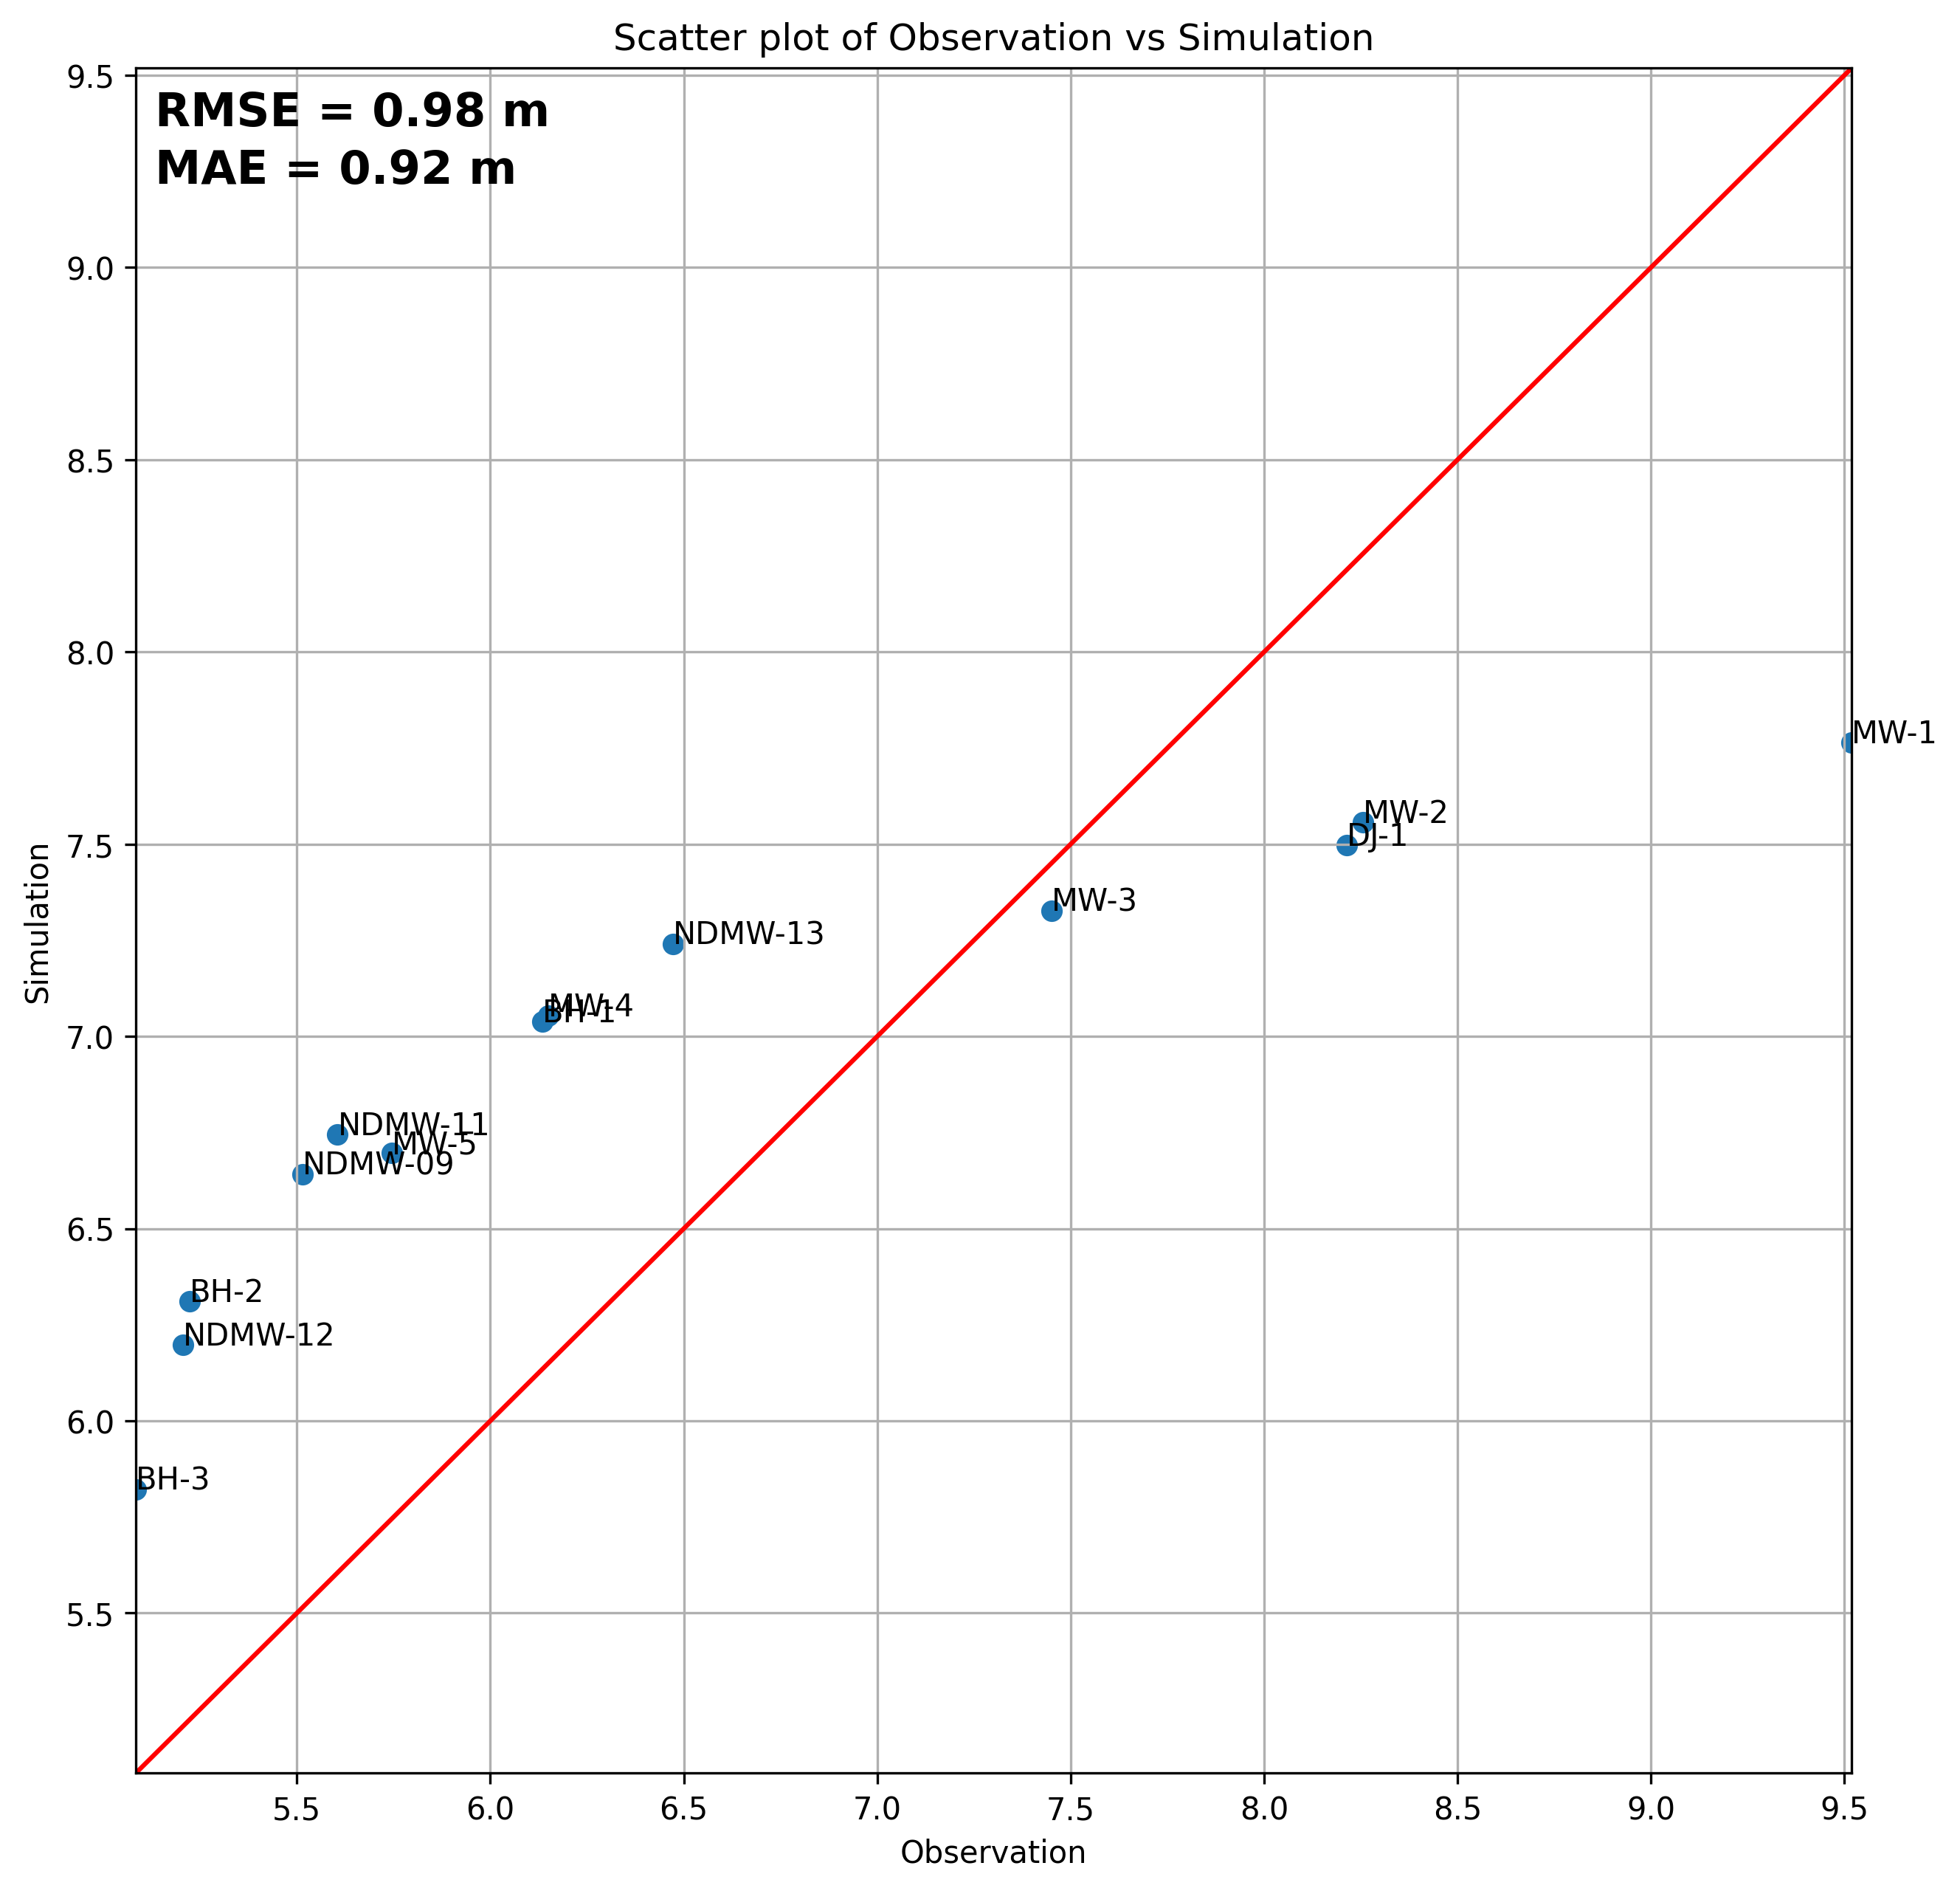

R^2 value:  0.4775963639980285


In [17]:
# 각 관측소의 관측값과 시뮬레이션 값 저장할 리스트
observation_values = []
simulation_values = []

# 각 관측소에 대해
for well_name, data in combined_dict.items():
    # 시뮬레이션 값(H 값) 가져오기
    H = data['H']
    
    # 관측 값(AVERAGE 값) 가져오기
    average = data['average']

    observation_values.append(average)
    simulation_values.append(H)

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(observation_values, simulation_values))
mae = mean_absolute_error(observation_values, simulation_values)
    
# 산점도 그리기
plt.figure(figsize=(10, 10), dpi = 300)
plt.scatter(observation_values, simulation_values, label='Data points')

# y=x 선 그리기
line_x = np.array([min(min(observation_values), min(simulation_values)), max(max(observation_values), max(simulation_values))])
plt.plot(line_x, line_x, color='red', label='y=x')

# 각 점에 대한 이름 표시
for i, well_name in enumerate(combined_dict.keys()):
    plt.annotate(well_name, (observation_values[i], simulation_values[i]))

plt.xlabel('Observation')
plt.ylabel('Simulation')
plt.title('Scatter plot of Observation vs Simulation')

# 범례 표시
# plt.legend()

# x와 y축의 범위 동일하게 설정
plt.xlim([min(min(observation_values), min(simulation_values)), max(max(observation_values), max(simulation_values))])
plt.ylim([min(min(observation_values), min(simulation_values)), max(max(observation_values), max(simulation_values))])

plt.text(min(min(observation_values), min(simulation_values))+0.05, max(max(observation_values), max(simulation_values))-0.15, f"RMSE = {rmse:.2f} m", fontsize=15, weight = 'bold')
plt.text(min(min(observation_values), min(simulation_values))+0.05, max(max(observation_values), max(simulation_values))-0.3, f"MAE = {mae:.2f} m", fontsize=15,weight = 'bold')

plt.grid(True)
plt.show()

# R^2 값 계산
r2 = r2_score(observation_values, simulation_values)
print("R^2 value: ", r2)


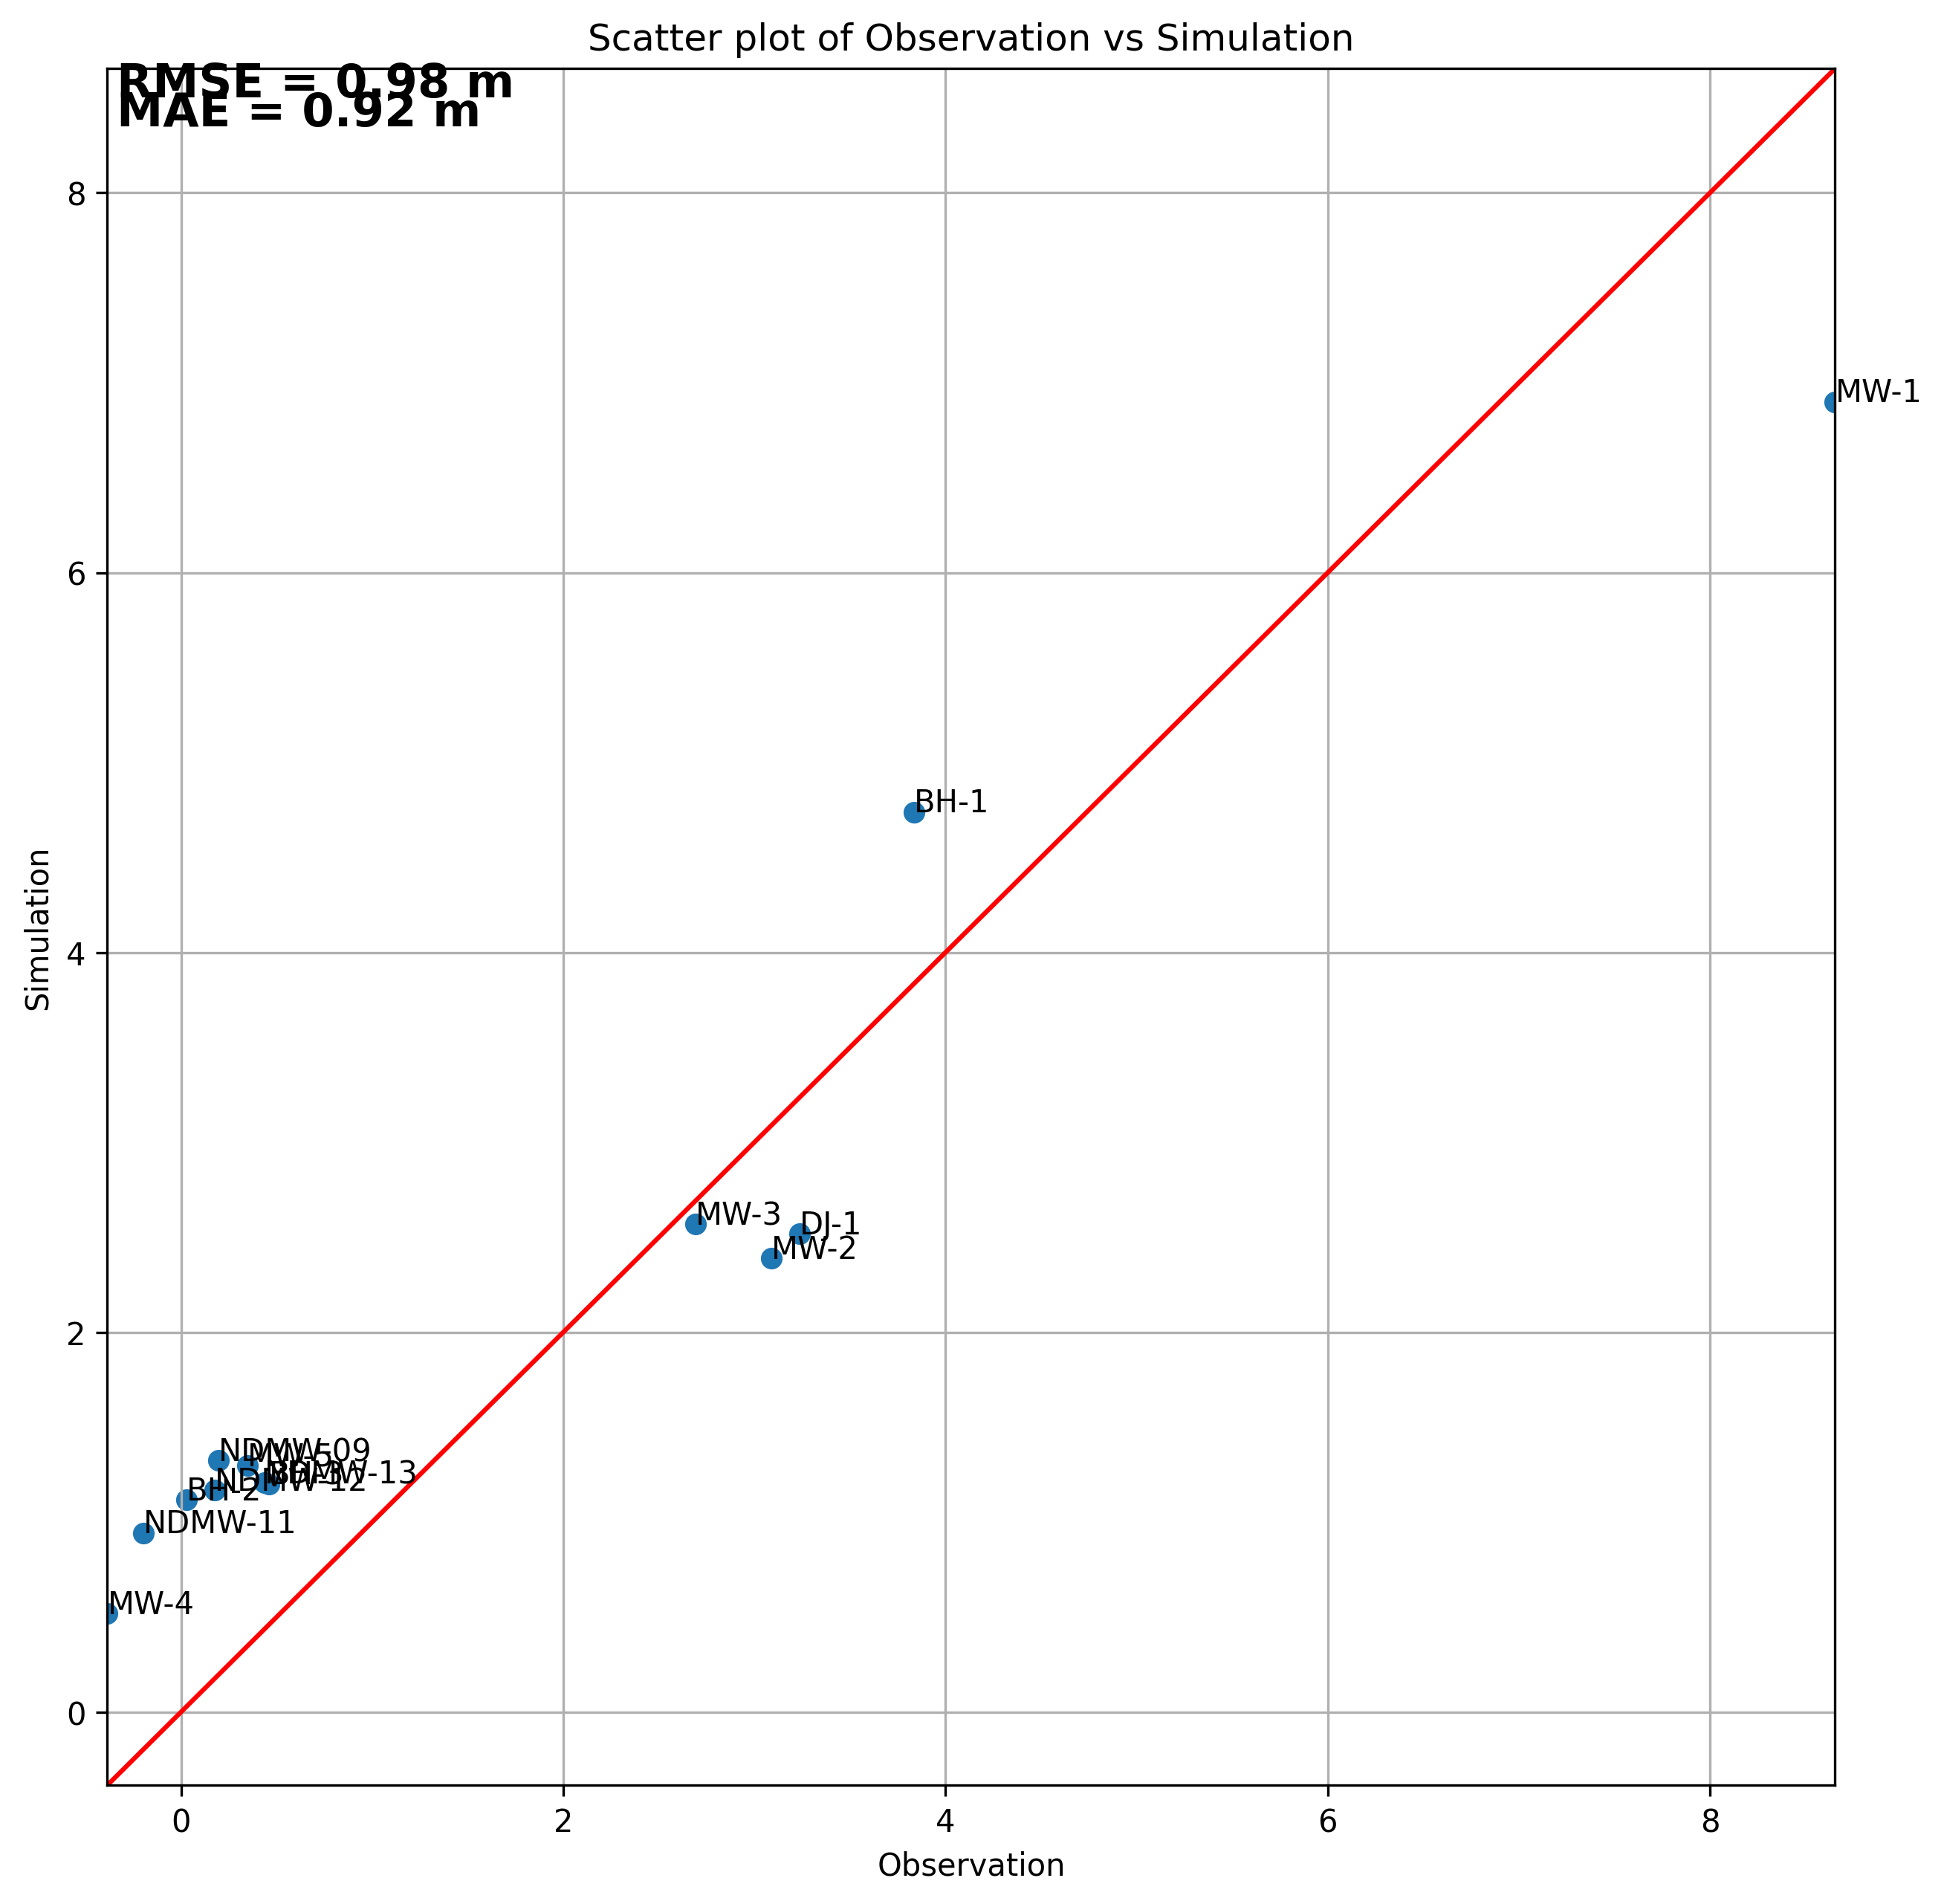

R^2 value:  0.8405328414568682


In [18]:
observation_values = []
simulation_values = []
# 각 관측소에 대해
for well_name, data in combined_dict.items():
    # 시뮬레이션 값(DTW 값) 가져오기
    DTW_S = data['DTW_S']
    
    # 관측 값(DTW 값) 가져오기
    DTW_O = data['DTW_O']

    observation_values.append(DTW_S)
    simulation_values.append(DTW_O)

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(observation_values, simulation_values))
mae = mean_absolute_error(observation_values, simulation_values)
    
# 산점도 그리기
plt.figure(figsize=(10, 10), dpi = 300)
plt.scatter(observation_values, simulation_values, label='Data points')

# y=x 선 그리기
line_x = np.array([min(min(observation_values), min(simulation_values)), max(max(observation_values), max(simulation_values))])
plt.plot(line_x, line_x, color='red', label='y=x')

# 각 점에 대한 이름 표시
for i, well_name in enumerate(combined_dict.keys()):
    plt.annotate(well_name, (observation_values[i], simulation_values[i]))

plt.xlabel('Observation')
plt.ylabel('Simulation')
plt.title('Scatter plot of Observation vs Simulation')

# 범례 표시
# plt.legend()

# x와 y축의 범위 동일하게 설정
plt.xlim([min(min(observation_values), min(simulation_values)), max(max(observation_values), max(simulation_values))])
plt.ylim([min(min(observation_values), min(simulation_values)), max(max(observation_values), max(simulation_values))])

plt.text(min(min(observation_values), min(simulation_values))+0.05, max(max(observation_values), max(simulation_values))-0.15, f"RMSE = {rmse:.2f} m", fontsize=15, weight = 'bold')
plt.text(min(min(observation_values), min(simulation_values))+0.05, max(max(observation_values), max(simulation_values))-0.3, f"MAE = {mae:.2f} m", fontsize=15,weight = 'bold')

plt.grid(True)
plt.show()

# R^2 값 계산
r2 = r2_score(observation_values, simulation_values)
print("R^2 value: ", r2)
